In [1]:
%matplotlib inline
import warnings

warnings.filterwarnings(
    "ignore",
    message="plotting functions contained within `_documentation_utils` are intended for nemos's documentation.",
    category=UserWarning,
)

warnings.filterwarnings(
    "ignore",
    message="Ignoring cached namespace 'core'",
    category=UserWarning,
)

warnings.filterwarnings(
    "ignore",
    message=(
        "invalid value encountered in div "
    ),
    category=RuntimeWarning,
)

:::{admonition} Download
:class: important render-all

This notebook can be downloaded as **{nb-download}`head_direction.ipynb`**. See the button at the top right to download as markdown or pdf.

:::

(head-direction-tutorial)=
# Fit head-direction population

## Learning objectives

- Include history-related predictors to NeMoS GLM.
- Reduce over-fitting with `Basis`.
- Learn functional connectivity.

<div class="render-user">
- Include history-related predictors to NeMoS GLM.
- Reduce over-fitting with `Basis`.
- Learn functional connectivity.
</div>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pynapple as nap

import nemos as nmo

# some helper plotting functions
from nemos import _documentation_utils as doc_plots
import workshop_utils

# configure pynapple to ignore conversion warning
nap.nap_config.suppress_conversion_warnings = True

# configure plots some
plt.style.use(nmo.styles.plot_style)

## Data Streaming

Here we load the data from OSF. The data is a NWB file.

<div class="render-user">
- Fetch the data.
</div>

In [3]:
path = workshop_utils.fetch.fetch_data("Mouse32-140822.nwb")

## Pynapple
We are going to open the NWB file with pynapple.

<div class="render-user">
- `load_file` : open the NWB file and give a preview.
</div>

In [4]:
data = nap.load_file(path)

data

/home/agent/workspace/rorse_ccn-software-jan-2025_main/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/agent/workspace/rorse_ccn-software-jan-2025_main/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Mouse32-140822
┍━━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━┑
│ Keys                  │ Type        │
┝━━━━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━┥
│ units                 │ TsGroup     │
│ sws                   │ IntervalSet │
│ rem                   │ IntervalSet │
│ position_time_support │ IntervalSet │
│ epochs                │ IntervalSet │
│ ry                    │ Tsd         │
┕━━━━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━┙

Get spike timings

<div class="render-user">
- Load the units
</div>

In [5]:
spikes = data["units"]

spikes

Index    rate     location    group
-------  -------  ----------  -------
0        2.96981  thalamus    1
1        2.42638  thalamus    1
2        5.93417  thalamus    1
3        5.04432  thalamus    1
4        0.30207  adn         2
5        0.87042  adn         2
6        0.36154  adn         2
...      ...      ...         ...
42       1.02061  thalamus    5
43       6.84913  thalamus    6
44       0.94002  thalamus    6
45       0.55768  thalamus    6
46       1.15056  thalamus    6
47       0.46084  thalamus    6
48       0.19287  thalamus    7

Get the behavioural epochs (in this case, sleep and wakefulness)

<div class="render-user">
- Load the epochs and take only wakefulness
</div>

In [6]:
epochs = data["epochs"]
wake_epochs = epochs[epochs.tags == "wake"]

/home/agent/workspace/rorse_ccn-software-jan-2025_main/lib/python3.11/site-packages/pynapple/io/interface_nwb.py:90: UserWarning: DataFrame is not sorted by start times. Sorting it.
  data = nap.IntervalSet(df)


Get the tracked orientation of the animal

<div class="render-user">
- Load the angular head-direction of the animal (in radians)
</div>

In [7]:
angle = data["ry"]

This cell will restrict the data to what we care about i.e. the activity of head-direction neurons during wakefulness.

<div class="render-user">
- Select only those units that are in ADn
- Restrict the activity to wakefulness (both the spiking activity and the angle)
</div>

In [8]:
spikes = spikes[spikes.location == "adn"]

spikes = spikes.restrict(wake_epochs).getby_threshold("rate", 1.0)
angle = angle.restrict(wake_epochs)

First let's check that they are head-direction neurons.

<div class="render-user">
- Compute tuning curves as a function of head-direction
</div>

In [9]:
tuning_curves = nap.compute_1d_tuning_curves(
    group=spikes, feature=angle, nb_bins=61, minmax=(0, 2 * np.pi)
)

Each row indicates an angular bin (in radians), and each column corresponds to a single unit.
Let's plot the tuning curve of the first two neurons.

<div class="render-user">
- Plot the tuning curves.
</div>

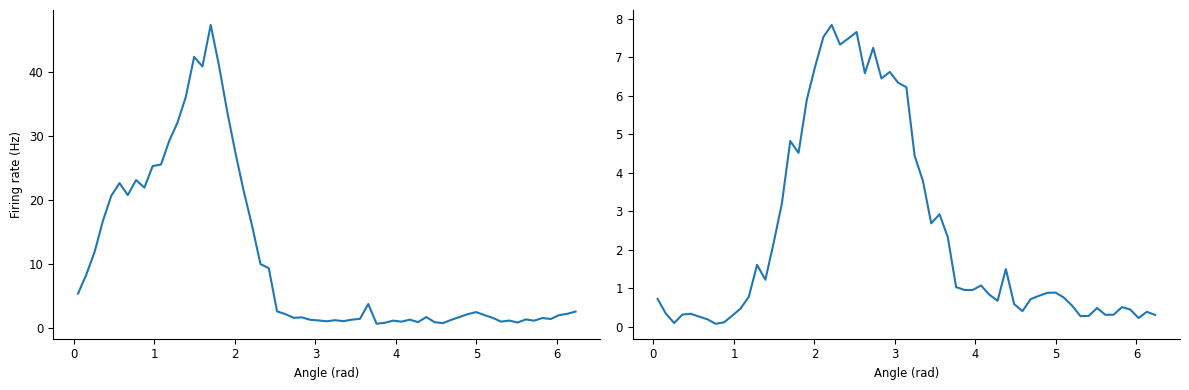

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(tuning_curves.iloc[:, 0])
ax[0].set_xlabel("Angle (rad)")
ax[0].set_ylabel("Firing rate (Hz)")
ax[1].plot(tuning_curves.iloc[:, 1])
ax[1].set_xlabel("Angle (rad)")
plt.tight_layout()

Before using NeMoS, let's explore the data at the population level.

Let's plot the preferred heading

<div class="render-user">
- Let's visualize the data at the population level.
</div>

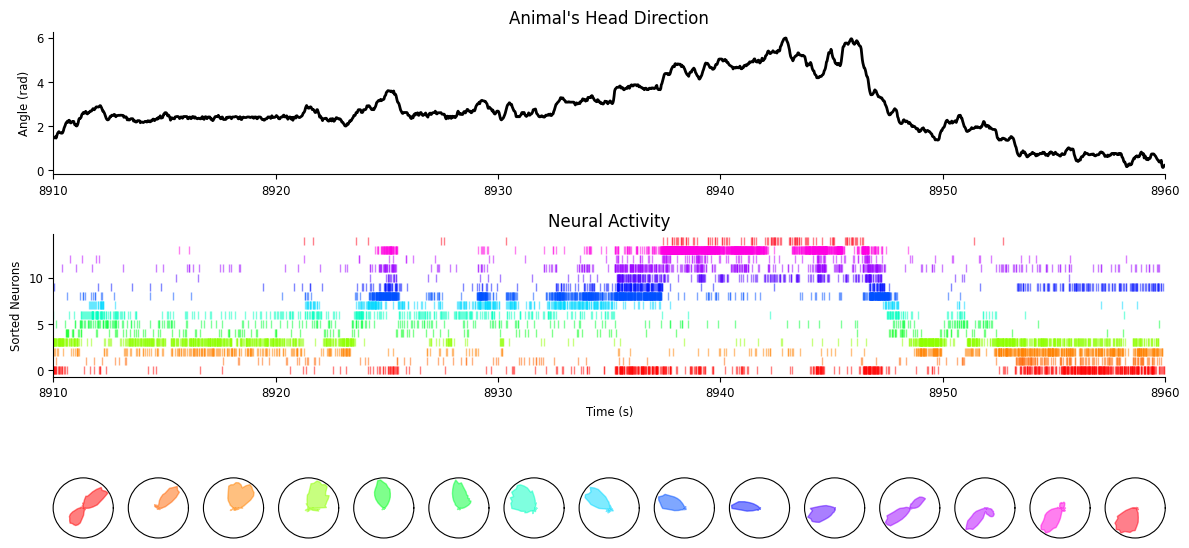

In [11]:
fig = workshop_utils.plot_head_direction_tuning_model(
    tuning_curves, spikes, angle, threshold_hz=1, start=8910, end=8960
)

As we can see, the population activity tracks very well the current head-direction of the animal.

**Question : are neurons constantly tuned to head-direction and can we use it to predict the spiking activity of each neuron based only on the activity of other neurons?**

To fit the GLM faster, we will use only the first 3 min of wake.

<div class="render-user">
- Define a `wake_ep` IntervalSet with the first 3 minutes of wakefulness (to speed up model fitting).
</div>

<div class="render-user">
```{code-cell} ipython3
wake_ep =
```
</div>

In [12]:
wake_ep = nap.IntervalSet(
    start=wake_epochs.start[0], end=wake_epochs.start[0] + 3 * 60
)

To use the GLM, we need first to bin the spike trains. Here we use pynapple.

<div class="render-user">
- bin the spike trains in 10 ms bin (`count = ...`).
</div>

<div class="render-user">
```{code-cell} ipython3
bin_size =
count =
```
</div>

In [13]:
bin_size = 0.01
count = spikes.count(bin_size, ep=wake_ep)

Here we are going to rearrange neurons order based on their preferred directions.

<div class="render-user">
- sort the neurons by their preferred direction using pandas:
    - Preferred angle:  `pref_ang = tuning_curves.idxmax()`.
    - Define a new `count` TsdFrame, sorting the columns according to `pref_ang`.
</div>

<div class="render-user">
```{code-cell} ipython3
pref_ang = tuning_curves.idxmax()
# sort the columns by angle
count = nap.TsdFrame(
```
</div>

In [14]:
pref_ang = tuning_curves.idxmax()

count = nap.TsdFrame(
    t=count.t,
    d=count.values[:, np.argsort(pref_ang.values)],
)

## NeMoS 
It's time to use NeMoS. Our goal is to estimate the pairwise interaction between neurons.
This can be quantified with a GLM if we use the recent population spike history to predict the current time step.
### Self-Connected Single Neuron
To simplify our life, let's see first how we can model spike history effects in a single neuron.
The simplest approach is to use counts in fixed length window $i$, $y_{t-i}, \dots, y_{t-1}$ to predict the next
count $y_{t}$. 

Before starting the analysis, let's select a neuron and a time window that we will use to visualize the model features.

<div class="render-user">
- Start with modeling a self-connected single neuron.
- Select a neuron (call the variable `neuron_count`).
- Select the first 1.2 seconds for visualization. (call the epoch `epoch_one_spk`).
</div>

<div class="render-user">
```{code-cell} ipython3
# select neuron 0 spike count time series
neuron_count =
# restrict to a smaller time interval (1.2 sec)
epoch_one_spk =
```
</div>

In [15]:
# select a neuron's spike count time series
neuron_count = count[:, 0]

# restrict to a smaller time interval
epoch_one_spk = nap.IntervalSet(
    start=count.time_support.start[0], end=count.time_support.start[0] + 1.2
)

#### Features Construction
Let's fix the spike history window size that we will use as predictor.

<div class="render-user">
- Fix a history window of 800ms (0.8 seconds).
- Plot the result using `doc_plots.plot_history_window`
</div>

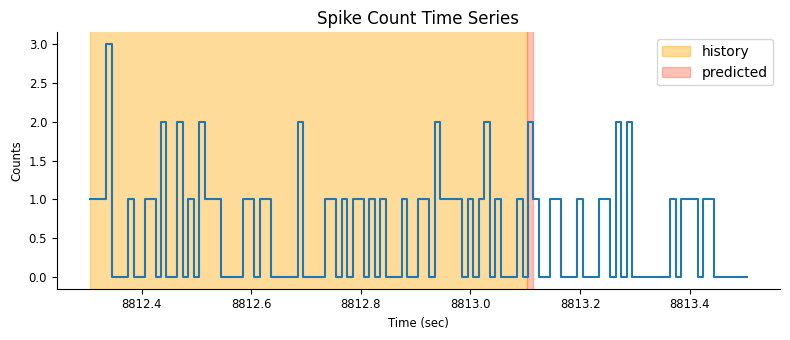

In [16]:
# set the size of the spike history window in seconds
window_size_sec = 0.8

doc_plots.plot_history_window(neuron_count, epoch_one_spk, window_size_sec);

For each time point, we shift our window one bin at the time and vertically stack the spike count history in a matrix.
Each row of the matrix will be used as the predictors for the rate in the next bin (red narrow rectangle in
the figure).

<div class="render-user">
- By shifting the time window we can predict new count bins.
- Concatenating all the shifts, we form our feature matrix.
</div>

In [17]:
doc_plots.run_animation(neuron_count, epoch_one_spk.start[0])

If $t$ is smaller than the window size, we won't have a full window of spike history for estimating the rate.
One may think of padding the window (with zeros for example) but this may generate weird border artifacts.
To avoid that, we can simply restrict our analysis to times $t$ larger than the window and NaN-pad earlier
time-points;

You can construct this feature matrix with the [`HistoryConv`](nemos.basis.HistoryConv) basis.

<div class="render-user">
- This is equivalent to convolving `count` with an identity matrix.
- That's what NeMoS `HistoryConv` basis is for: 
    - Convert the window size in number of bins (call it `window_size`)
    - Define an `HistoryConv` basis covering this window size (call it `history_basis`).
    - Create the feature matrix with `history_basis.compute_features` (call it `input_feature`).
</div>

<div class="render-user">
```{code-cell} ipython3
# convert the prediction window to bins (by multiplying with the sampling rate)
window_size =
# define the history bases
history_basis =
# create the feature matrix
input_feature =
```
</div>

In [18]:
# convert the prediction window to bins (by multiplying with the sampling rate)
window_size = int(window_size_sec * neuron_count.rate)
# define the history bases
history_basis = nmo.basis.HistoryConv(window_size)
# create the feature matrix
input_feature = history_basis.compute_features(neuron_count)

/home/agent/workspace/rorse_ccn-software-jan-2025_main/lib/python3.11/site-packages/pynapple/core/time_series.py:300: DeprecationWarning: `newshape` keyword argument is deprecated, use `shape=...` or pass shape positionally instead. (deprecated in NumPy 2.1)
  out = func._implementation(*new_args, **kwargs)


<div class="render-user">
- NeMoS NaN pads if there aren't enough samples to predict the counts. 
</div>

In [19]:
# print the NaN indices along the time axis
print("NaN indices:\n", np.where(np.isnan(input_feature[:, 0]))[0]) 

NaN indices:
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79]


The binned counts originally have shape "number of samples", we should check that the
dimension are matching our expectation

<div class="render-user">
- Check the shape of the counts and features.
</div>

In [20]:
print(f"Time bins in counts: {neuron_count.shape[0]}")
print(f"Convolution window size in bins: {window_size}")
print(f"Feature shape: {input_feature.shape}")
print(f"Feature shape: {input_feature.shape}")

Time bins in counts: 18000
Convolution window size in bins: 80
Feature shape: (18000, 80)
Feature shape: (18000, 80)


We can visualize the output for a few time bins

<div class="render-user">
- Plot the convolution output with `workshop_utils.plot_features`.
</div>

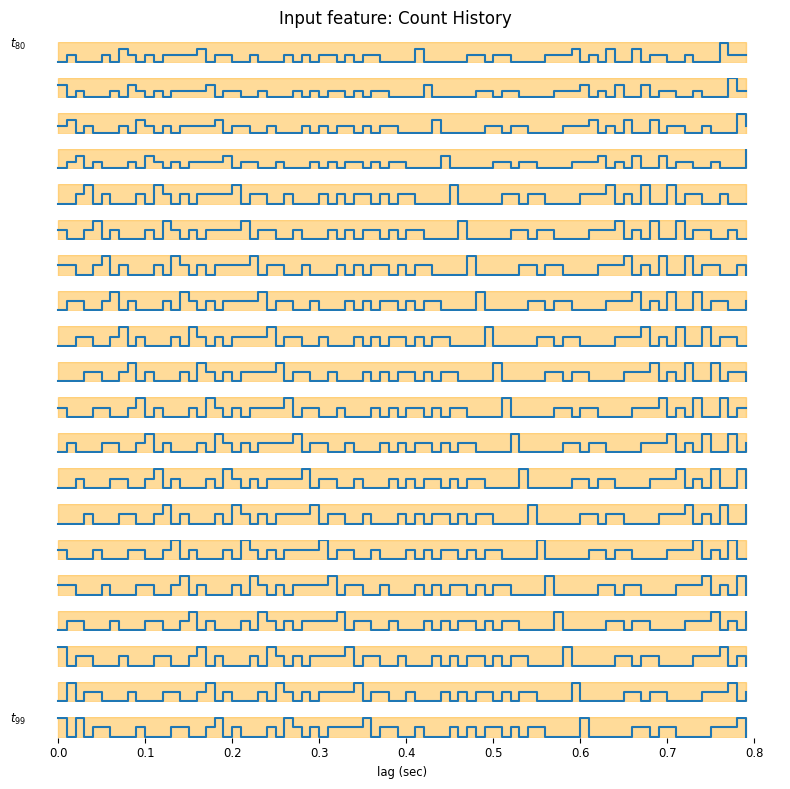

In [21]:
suptitle = "Input feature: Count History"
neuron_id = 0
workshop_utils.plot_features(input_feature, count.rate, suptitle);

As you may see, the time axis is backward, this happens because under the hood, the basis is using the convolution operator which flips the time axis.
This is equivalent, as we can interpret the result as how much a spike will affect the future rate.
In the previous tutorial our feature was 1-dimensional (just the current), now
instead the feature dimension is 80, because our bin size was 0.01 sec and the window size is 0.8 sec.
We can learn these weights by maximum likelihood by fitting a GLM.




#### Fitting the Model

When working a real dataset, it is good practice to train your models on a chunk of the data and
use the other chunk to assess the model performance. This process is known as "cross-validation".
There is no unique strategy on how to cross-validate your model; What works best
depends on the characteristic of your data (time series or independent samples,
presence or absence of trials...), and that of your model. Here, for simplicity use the first
half of the wake epochs for training and the second half for testing. This is a reasonable
choice if the statistics of the neural activity does not change during the course of
the recording. We will learn about better cross-validation strategies with other
examples.

<div class="render-user">
- Split your epochs in two for validation purposes:
    - Define two `IntervalSet`s, each with half of the `input_feature.time_support` duration
</div>

In [22]:
# construct the train and test epochs
duration = input_feature.time_support.tot_length("s")
start = input_feature.time_support["start"]
end = input_feature.time_support["end"]

# define the interval sets
first_half = nap.IntervalSet(start, start + duration / 2)
second_half = nap.IntervalSet(start + duration / 2, end)

Fit the glm to the first half of the recording and visualize the maximum likelihood weights.

<div class="render-user">
- Fit a GLM to the first half. 
</div>

<div class="render-user">
```{code-cell} ipython3
# define the GLM object
model = 
# Fit over the training epochs
```
</div>

In [23]:
# define the GLM object
model = nmo.glm.GLM(solver_name="LBFGS")

# Fit over the training epochs
model.fit(
    input_feature.restrict(first_half),
    neuron_count.restrict(first_half)
)

GLM(
    observation_model=PoissonObservations(inverse_link_function=exp),
    regularizer=UnRegularized(),
    solver_name='LBFGS'
)

<div class="render-user">
- Plot the weights (`model.coef_`).
</div>

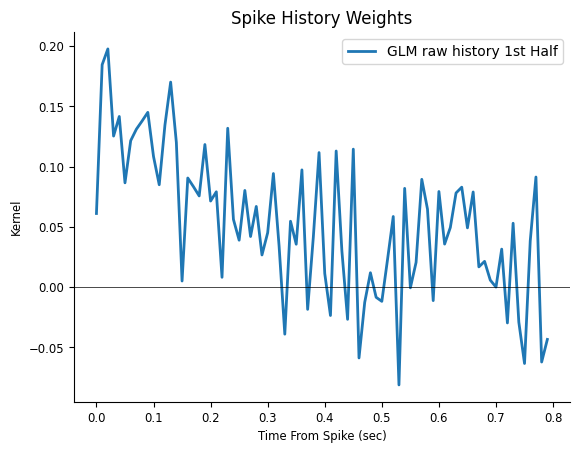

In [24]:
plt.figure()
plt.title("Spike History Weights")
plt.plot(np.arange(window_size) / count.rate, np.squeeze(model.coef_), lw=2, label="GLM raw history 1st Half")
plt.axhline(0, color="k", lw=0.5)
plt.xlabel("Time From Spike (sec)")
plt.ylabel("Kernel")
plt.legend()

The response in the previous figure seems noise added to a decay, therefore the response
can be described with fewer degrees of freedom. In other words, it looks like we
are using way too many weights to describe a simple response.
If we are correct, what would happen if we re-fit the weights on the other half of the data?

#### Inspecting the results

<div class="render-user">
- Fit on the other half.
</div>

<div class="render-user">
```{code-cell} ipython3
# fit on the test set
model_second_half = 
```
</div>

In [25]:
# fit on the test set

model_second_half = nmo.glm.GLM(solver_name="LBFGS")
model_second_half.fit(
    input_feature.restrict(second_half),
    neuron_count.restrict(second_half)
)

GLM(
    observation_model=PoissonObservations(inverse_link_function=exp),
    regularizer=UnRegularized(),
    solver_name='LBFGS'
)

<div class="render-user">
- Compare results.
</div>

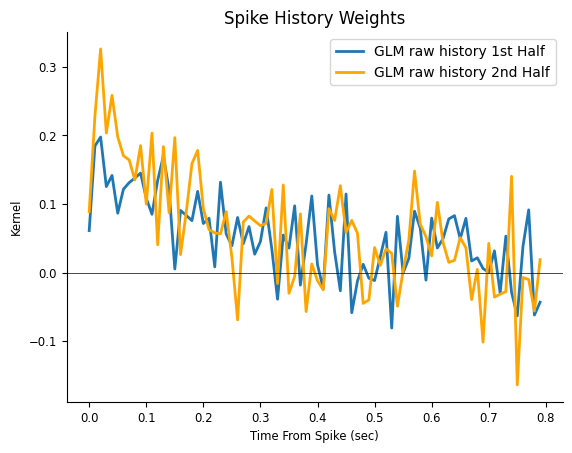

In [26]:
plt.figure()
plt.title("Spike History Weights")
plt.plot(np.arange(window_size) / count.rate, np.squeeze(model.coef_),
         label="GLM raw history 1st Half", lw=2)
plt.plot(np.arange(window_size) / count.rate,  np.squeeze(model_second_half.coef_),
         color="orange", label="GLM raw history 2nd Half", lw=2)
plt.axhline(0, color="k", lw=0.5)
plt.xlabel("Time From Spike (sec)")
plt.ylabel("Kernel")
plt.legend()

What can we conclude?

The fast fluctuations are inconsistent across fits, indicating that
they are probably capturing noise, a phenomenon known as over-fitting;
On the other hand, the decaying trend is fairly consistent, even if
our estimate is noisy. You can imagine how things could get
worst if we needed a finer temporal resolution, such 1ms time bins
(which would require 800 coefficients instead of 80).
What can we do to mitigate over-fitting now?

(head_direction_reducing_dimensionality)=
#### Reducing feature dimensionality
Let's see how to use NeMoS' `basis` module to reduce dimensionality and avoid over-fitting!
For history-type inputs, we'll use again the raised cosine log-stretched basis,
[Pillow et al., 2005](https://www.jneurosci.org/content/25/47/11003).

<div class="render-user">
- Visualize the raised cosine basis.
</div>

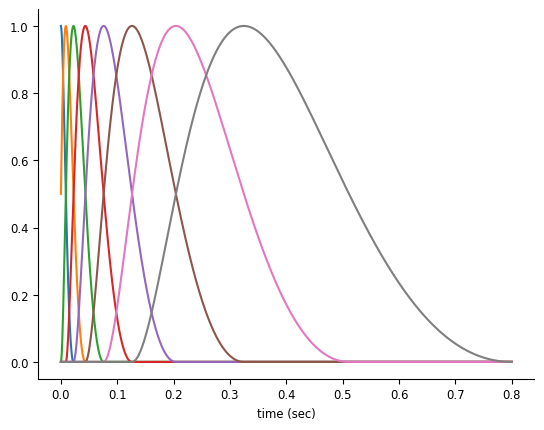

In [27]:
doc_plots.plot_basis();

:::{note}

We provide a handful of different choices for basis functions, and
selecting the proper basis function for your input is an important
analytical step. We will eventually provide guidance on this choice, but
for now we'll give you a decent choice.
:::

We can initialize the `RaisedCosineLogConv` by providing the number of basis functions and the window size for the convolution. With more basis functions, we'll be able to represent the effect of the corresponding input with the higher precision, at the cost of adding additional parameters.

<div class="render-user">
- Define the basis `RaisedCosineLogConv`and name it `basis`. 
- Basis parameters:
    - 8 basis functions.
    - Window size of 0.8sec.
</div>

<div class="render-user">
```{code-cell} ipython3
# a basis object can be instantiated in "conv" mode for convolving  the input.
basis =
```
</div>

In [28]:
# a basis object can be instantiated in "conv" mode for convolving  the input.
basis = nmo.basis.RaisedCosineLogConv(
    n_basis_funcs=8, window_size=window_size
)

Our spike history predictor was huge: every possible 80 time point chunk of the
data, for $144 \cdot 10^4$ total numbers. By using this basis set we can instead reduce
the predictor to 8 numbers for every 80 time point window for $144 \cdot 10^3$ total
numbers, an order of magnitude less. With 1ms bins we would have
achieved 2 order of magnitude reduction in input size. This is a huge benefit
in terms of memory allocation and, computing time. As an additional benefit,
we will reduce over-fitting.

Let's see our basis in action. We can "compress" spike history feature by convolving the basis
with the counts (without creating the large spike history feature matrix).
This can be performed in NeMoS by calling the `compute_features` method of basis.

<div class="render-user">
- Convolve the counts with the basis functions. (Call the output `conv_spk`)
- Print the shape of `conv_spk` and compare it to `input_feature`.
</div>

<div class="render-user">
```{code-cell} ipython3
# convolve the basis
conv_spk =
# print the shape
print(f"Raw count history as feature: {input_feature.shape}")
print(f"Compressed count history as feature: {conv_spk.shape}")
```
</div>

In [29]:
# equivalent to
# `nmo.convolve.create_convolutional_predictor(basis_kernels, neuron_count)`
conv_spk = basis.compute_features(neuron_count)

print(f"Raw count history as feature: {input_feature.shape}")
print(f"Compressed count history as feature: {conv_spk.shape}")

Raw count history as feature: (18000, 80)
Compressed count history as feature: (18000, 8)


/home/agent/workspace/rorse_ccn-software-jan-2025_main/lib/python3.11/site-packages/pynapple/core/time_series.py:300: DeprecationWarning: `newshape` keyword argument is deprecated, use `shape=...` or pass shape positionally instead. (deprecated in NumPy 2.1)
  out = func._implementation(*new_args, **kwargs)


Let’s focus on two small time windows and visualize the features, which result from convolving the counts with the basis elements.

<div class="render-user">
- Visualize the output.
</div>

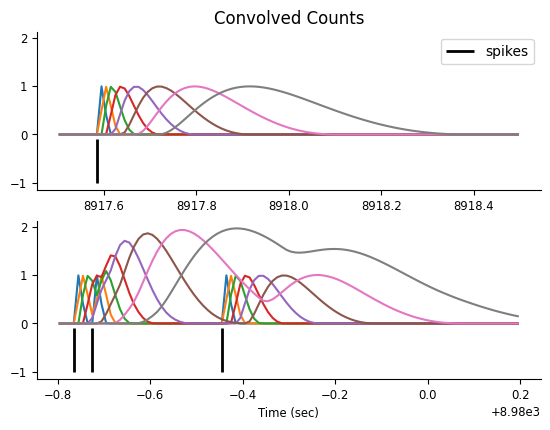

In [30]:
# Visualize the convolution results
epoch_one_spk = nap.IntervalSet(8917.5, 8918.5)
epoch_multi_spk = nap.IntervalSet(8979.2, 8980.2)

doc_plots.plot_convolved_counts(neuron_count, conv_spk, epoch_one_spk, epoch_multi_spk);

Now that we have our "compressed" history feature matrix, we can fit the ML parameters for a GLM.


#### Fit and compare the models

<div class="render-user">
- Fit the model using the compressed features. Call it `model_basis`.
</div>

<div class="render-user">
```{code-cell} ipython3
# use restrict on interval set training and fit a GLM
model_basis =
```
</div>

In [31]:
# use restrict on interval set training
model_basis = nmo.glm.GLM(solver_name="LBFGS")
model_basis.fit(conv_spk.restrict(first_half), neuron_count.restrict(first_half))

GLM(
    observation_model=PoissonObservations(inverse_link_function=exp),
    regularizer=UnRegularized(),
    solver_name='LBFGS'
)

We can plot the resulting response, noting that the weights we just learned needs to be "expanded" back
to the original `window_size` dimension by multiplying them with the basis kernels.
We have now 8 coefficients,

In [32]:
print(model_basis.coef_)

[ 0.00699737  0.11532708  0.11950959  0.02769178  0.06939367  0.08511728
 -0.00209078  0.05547396]


In order to get the response we need to multiply the coefficients by their corresponding
basis function, and sum them.

<div class="render-user">
- Reconstruct the history filter:
    - Extract the basis kernels with `_, basis_kernels = basis.evaluate_on_grid(window_size)`.
    - Multiply the `basis_kernel` with the coefficient using `np.matmul`.
- Check the shape of `self_connection`.
</div>

<div class="render-user">
```{code-cell} ipython3
# get the basis function kernels
_, basis_kernels = 
# multiply with the weights
self_connection = 
# print the shape of self_connection
```
</div>

In [33]:
# get the basis function kernels
_, basis_kernels = basis.evaluate_on_grid(window_size)

# multiply with the weights
self_connection = np.matmul(basis_kernels, model_basis.coef_)

print(self_connection.shape)

(80,)


Let's check if our new estimate does a better job in terms of over-fitting. We can do that
by visual comparison, as we did previously. Let's fit the second half of the dataset.

<div class="render-user">
- Check if with less parameter we are not over-fitting.
- Fit the other half of the data. Name it `model_basis_second_half`.
</div>

<div class="render-user">
```{code-cell} ipython3
model_basis_second_half = 
```
</div>

In [34]:
model_basis_second_half = nmo.glm.GLM(solver_name="LBFGS").fit(
    conv_spk.restrict(second_half), neuron_count.restrict(second_half)
)

Get the response filters.

<div class="render-user">
- Get the response filters: multiply the `basis_kernels` with the weights from `model_basis_second_half`.
- Call the output `self_connection_second_half`.
</div>

<div class="render-user">
```{code-cell} ipython3
self_connection_second_half = 
```
</div>

In [35]:
self_connection_second_half = np.matmul(basis_kernels, model_basis_second_half.coef_)

<div class="render-user">
- Plot and compare the results.
</div>

And plot the results.

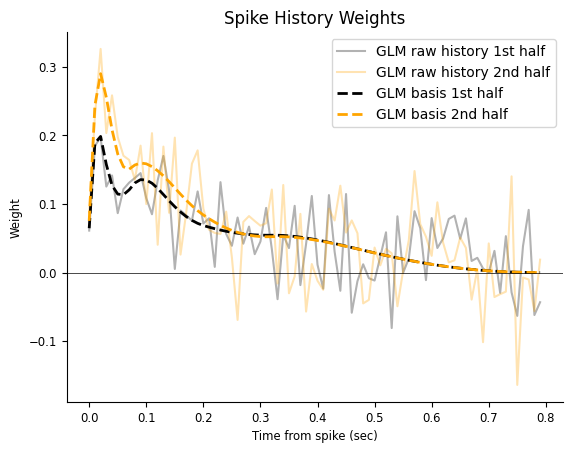

In [36]:
time = np.arange(window_size) / count.rate
plt.figure()
plt.title("Spike History Weights")
plt.plot(time, np.squeeze(model.coef_), "k", alpha=0.3, label="GLM raw history 1st half")
plt.plot(time, np.squeeze(model_second_half.coef_), alpha=0.3, color="orange", label="GLM raw history 2nd half")
plt.plot(time, self_connection, "--k", lw=2, label="GLM basis 1st half")
plt.plot(time, self_connection_second_half, color="orange", lw=2, ls="--", label="GLM basis 2nd half")
plt.axhline(0, color="k", lw=0.5)
plt.xlabel("Time from spike (sec)")
plt.ylabel("Weight")
plt.legend()

Let's extract the firing rate.

<div class="render-user">
- Predict the rates from `model` and `model_basis`. Call it `rate_history` and `rate_basis`.
- Convert the rate from spike/bin to spike/sec by multiplying with `conv_spk.rate`.
</div>

In [37]:
rate_basis = model_basis.predict(conv_spk) * conv_spk.rate
rate_history = model.predict(input_feature) * conv_spk.rate

And plot it.

<div class="render-user">
- Plot the results.
</div>

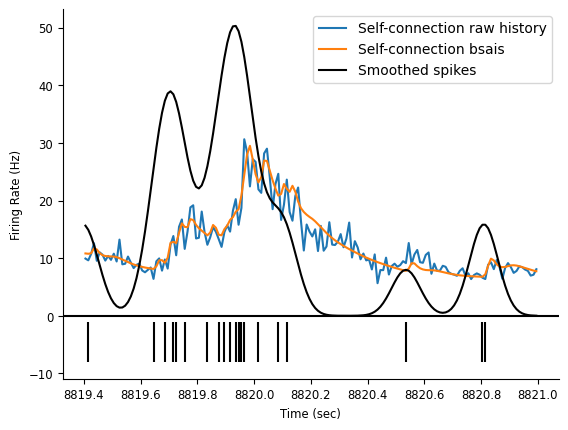

In [38]:
ep = nap.IntervalSet(start=8819.4, end=8821)
# plot the rates
doc_plots.plot_rates_and_smoothed_counts(
    neuron_count,
    {"Self-connection raw history":rate_history, "Self-connection bsais": rate_basis}
);

### All-to-all Connectivity
The same approach can be applied to the whole population. Now the firing rate of a neuron
is predicted not only by its own count history, but also by the rest of the
simultaneously recorded population. We can convolve the basis with the counts of each neuron
to get an array of predictors of shape, `(num_time_points, num_neurons * num_basis_funcs)`.

#### Preparing the features

<div class="render-user">
- Re-define the basis.
- Convolve all counts. Call the output in `convolved_count`.
- Print the output shape
</div>

Since this time we are convolving more than one neuron, we need to reset the expected input shape. This can be done by passing the population counts to the `set_input_shape` method.

<div class="render-user">
```{code-cell} ipython3
# reset the input shape by passing the pop. count
basis =
# convolve all the neurons
convolved_count = 
```
</div>

In [39]:
# reset the input shape by passing the pop. count
basis.set_input_shape(count)

# convolve all the neurons
convolved_count = basis.compute_features(count)

/home/agent/workspace/rorse_ccn-software-jan-2025_main/lib/python3.11/site-packages/pynapple/core/time_series.py:300: DeprecationWarning: `newshape` keyword argument is deprecated, use `shape=...` or pass shape positionally instead. (deprecated in NumPy 2.1)
  out = func._implementation(*new_args, **kwargs)


Check the dimension to make sure it make sense
Shape should be (n_samples, n_basis_func * n_neurons)

In [40]:
print(f"Convolved count shape: {convolved_count.shape}")

Convolved count shape: (18000, 152)


#### Fitting the Model
This is an all-to-all neurons model.
We are using the class [`PopulationGLM`](nemos.glm.PopulationGLM) to fit the whole population at once.

:::{note}

Once we condition on past activity, log-likelihood of the population is the sum of the log-likelihood
of individual neurons. Maximizing the sum (i.e. the population log-likelihood) is equivalent to
maximizing each individual term separately (i.e. fitting one neuron at the time).
:::

<div class="render-user">
- Fit a `PopulationGLM`, call the object `model`
- Use Ridge regularization with a `regularizer_strength=0.1`
- Print the shape of the estimated coefficients.
</div>

<div class="render-user">
```{code-cell} ipython3
model =
print(f"Model coefficients shape: {model.coef_.shape}")
```
</div>

In [41]:
model = nmo.glm.PopulationGLM(
    regularizer="Ridge",
    solver_name="LBFGS",
    regularizer_strength=0.1
    ).fit(convolved_count, count)

print(f"Model coefficients shape: {model.coef_.shape}")

Model coefficients shape: (152, 19)


#### Comparing model predictions.
Predict the rate (counts are already sorted by tuning prefs)

<div class="render-user">
- Predict the firing rate of each neuron. Call it `predicted_firing_rate`.
- Convert the rate from spike/bin to spike/sec.
</div>

<div class="render-user">
```{code-cell} ipython3
predicted_firing_rate =
```
</div>

In [42]:
predicted_firing_rate = model.predict(convolved_count) * conv_spk.rate

Plot fit predictions over a short window not used for training.

<div class="render-user">
- Visualize the predicted rate and tuning function.
</div>

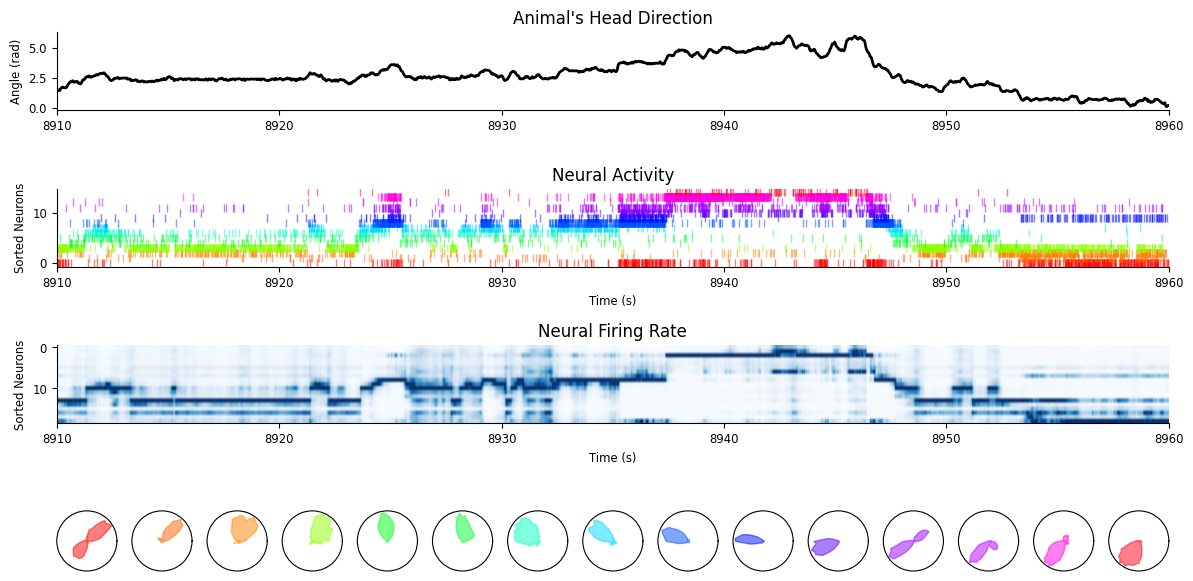

In [43]:
# use pynapple for time axis for all variables plotted for tick labels in imshow
workshop_utils.plot_head_direction_tuning_model(tuning_curves, spikes, angle, 
                                                predicted_firing_rate, threshold_hz=1,
                                                start=8910, end=8960, cmap_label="hsv");

Let's see if our firing rate predictions improved and in what sense.

<div class="render-user">
- Visually compare all the models.
</div>

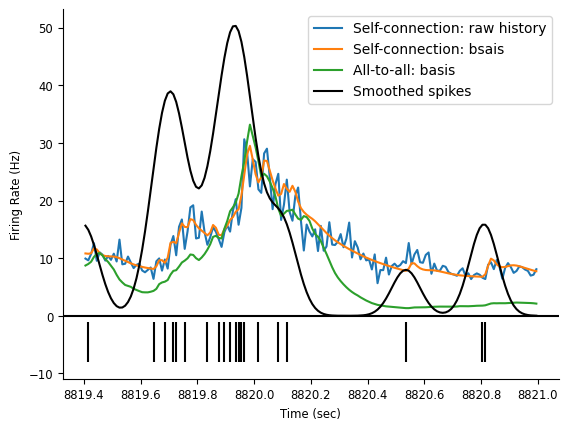

In [44]:
fig = doc_plots.plot_rates_and_smoothed_counts(
    neuron_count,
    {"Self-connection: raw history": rate_history,
     "Self-connection: bsais": rate_basis,
     "All-to-all: basis": predicted_firing_rate[:, 0]}
)

#### Visualizing the connectivity

Extract the weights and store it in a `(n_neurons, n_neurons, n_basis_funcs)` array. 

<div class="render-user">
- Check the shape of the weights.
</div>

In [45]:
# original shape of the weights
print(f"GLM coeff: {model.coef_.shape}")

GLM coeff: (152, 19)


You can use the `split_by_feature` method of `basis` for this. 

<div class="render-user">
- Reshape the weights with `basis.split_by_feature` (returns a dictionary).
</div>

<div class="render-all">

![Reshape coefficients](../../_static/coeff_reshape.png)

</div>


<div class="render-user">
```{code-cell} ipython3
# split the coefficient vector along the feature axis (axis=0)
weights_dict =
# visualize the content
weights_dict
```
</div>

<div class="render-user">
- Get the weight array from the dictionary (and call the output `weights`). 
- Print the new shape of the weights.
</div>

<div class="render-user">
```{code-cell} ipython3
# get the coefficients
weights = 
# print the shape
print(
```
</div>

In [46]:
# split the coefficient vector along the feature axis (axis=0)
weights_dict = basis.split_by_feature(model.coef_, axis=0)

# the output is a dict with key the basis label, 
# and value the reshaped coefficients
weights = weights_dict["RaisedCosineLogConv"]
print(f"Re-shaped coeff: {weights.shape}")

Re-shaped coeff: (19, 8, 19)


<div class="render-user">
- The shape is `(sender_neuron, num_basis, receiver_neuron)`.
- Multiply the weights with the kernels with: `np.einsum("jki,tk->ijt", weights, basis_kernels)`.
- Call the output `responses` and print its shape.
</div>

Multiply the weights by the basis, to get the history filters.

In [47]:
responses = np.einsum("jki,tk->ijt", weights, basis_kernels)

print(responses.shape)

(19, 19, 80)


Finally, we can visualize the pairwise interactions by plotting
all the coupling filters.

<div class="render-user">
- Plot the connectivity map.
</div>

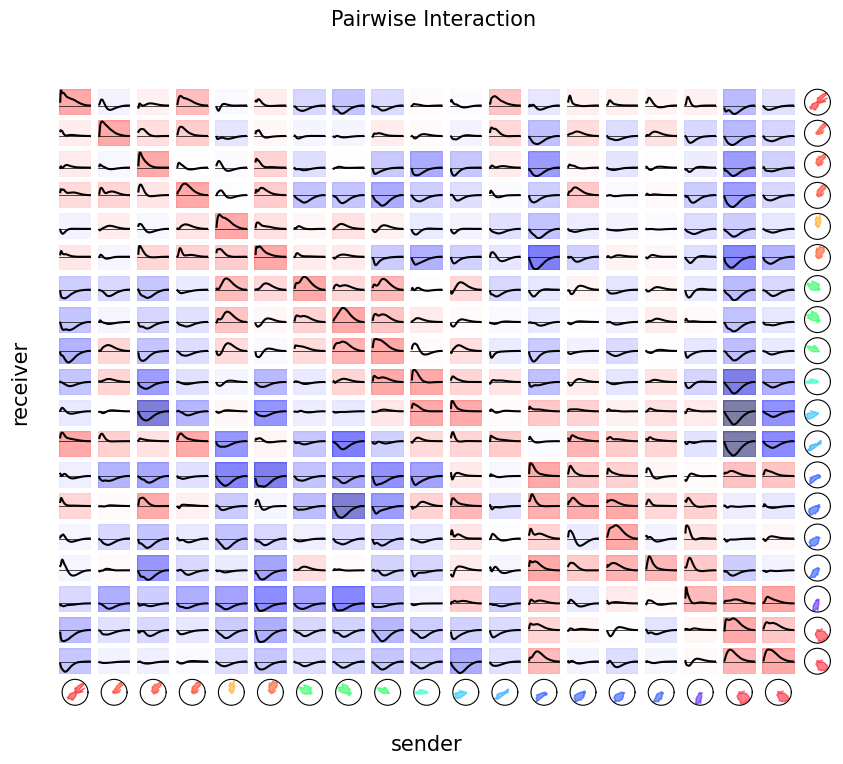

In [48]:
tuning = nap.compute_1d_tuning_curves_continuous(predicted_firing_rate,
                                                 feature=angle,
                                                 nb_bins=61,
                                                 minmax=(0, 2 * np.pi))
                                                 
fig = doc_plots.plot_coupling(responses, tuning)